# **B401 Continuous-time Derivatives Pricing**
*submitted by Tim-Moritz Bündert on July 26, 2021*

This notebook contains the code and results associated with the document *Bündert_CTDP_Assignment.pdf*.

**References**

Hull, J. (2015). Options, futures and other derivatives, 9th edition. Upper Saddle River, NJ: Prentice Hall ECB (2018). Statistics Paper Series No 27, February 2018. 

Deutsche Bundesbank (1997). Schätzung von Zinsstrukturkurven. Monatsbericht. Oktober 1997. 

**Table of Contents**

0. [Technical setup](#setup)
1. [Part I. - II.: Product selection and product characteristics](#I_II)
2. [Part III. - IV.: Parameter selection and valuation](#III_IV)
3. [Part V.: Sensitivity Analysis](#V)
4. [Part VI.: Replicating Portfolio](#VI)
5. [Part VII.: Performance Analysis](#VII)
5. [Part VIII.: Stress Scenario Analysis](#VIII)
5. [Part IX.: Risk Classification](#IX)

# Technical Setup <a id="setup"></a>

In [1]:
# import modules required for this analysis

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime as dt
import datetime
from tqdm.notebook import tqdm
from copy import deepcopy
from sklearn.neighbors import KernelDensity
from scipy import interpolate

# Part I. - II.: Product selection and product characteristics <a id="I_II"></a>

In [2]:
# function to determine payoffs at maturity for visualization 

def EC_Payoff(s):
  if s < barrier:
    return (100 * s) / 15.105
  elif (s >= barrier) and (s < strike):
    return 100
  else:
    return 132.5

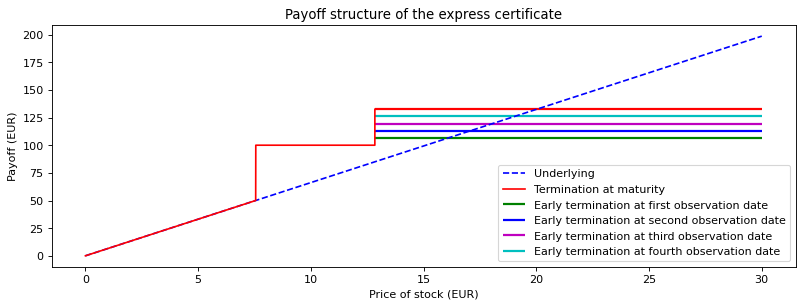

In [3]:
# visualization of the payoff structure

barrier = 7.553
strike = 12.839
upper_bound = 30
stock = np.arange(0, upper_bound, 0.001)

underlying = 100 * stock / 15.105

EC_base = np.array([EC_Payoff(s) for s in stock[:np.where(stock >= strike)[0][1]]])


fig = plt.figure(figsize=(12, 4), dpi=80)
plt.plot(stock, underlying, 'b--', label = "Underlying");
plt.plot(stock[:np.where(stock >= strike)[0][1]], EC_base, 'r', label = "Termination at maturity");
plt.hlines(y = 106.50, xmin = stock[np.where(stock >= strike)[0][1]], xmax = upper_bound, linewidth=2, color='g', label = "Early termination at first observation date")
plt.hlines(y = 113, xmin = stock[np.where(stock >= strike)[0][1]], xmax = upper_bound, linewidth=2, color='b', label = "Early termination at second observation date")
plt.hlines(y = 119.50, xmin = stock[np.where(stock >= strike)[0][1]], xmax = upper_bound, linewidth=2, color='m', label = "Early termination at third observation date")
plt.hlines(y = 126, xmin = stock[np.where(stock >= strike)[0][1]], xmax = upper_bound, linewidth=2, color='c', label = "Early termination at fourth observation date") #Early exercise
plt.hlines(y = 132.5, xmin = stock[np.where(stock >= strike)[0][1]], xmax = upper_bound, linewidth=2, color='r')

plt.xlabel("Price of stock (EUR)", fontsize=10)
plt.ylabel("Payoff (EUR)", fontsize=10)
plt.title("Payoff structure of the express certificate")
plt.legend(loc = "lower right");

# Part III. - IV.: Parameter selection and valuation <a id="III_IV"></a>

## Load stock and EC prices

In [4]:
# Load the prices of the EC certificate (Source: https://www.onvista.de/derivate/express-zertifikate/EXPRESS-ZERTIFIKAT-AUF-DEUTSCHE-LUFTHANSA-DE000DB9UYE4?exchange=@DE&timespan=undefined)

EC_prices = pd.read_csv("data/Price_EC.csv", sep = ";", decimal = ",") 
EC_prices = EC_prices.reindex(index=EC_prices.index[::-1])
print(EC_prices.shape)
EC_prices.head()

# As Lufthansa did not pay out any dividends in the period under consideration, it does not have to be accounted for the dividend yield.
# (Source: https://investor-relations.lufthansagroup.com/de/aktie-anleihen/dividende.html)

(496, 5)


,Datum,Eröffnung,Schluss,Hoch,Tief
495,05.07.2019,100.53,101.12,101.62,99.80
494,08.07.2019,99.93,99.73,100.31,99.58
493,09.07.2019,99.63,98.71,99.65,98.06
492,10.07.2019,98.63,99.10,99.65,98.50
491,11.07.2019,99.25,98.76,99.26,98.13


In [5]:
# Load the prices of the EC certificate (Source: https://www.onvista.de/aktien/times+sales/Lufthansa-Aktie-DE0008232125)

LHA = pd.read_csv("data/LHA.csv", sep = ";", decimal = ",") 
LHA.shape

(765, 6)

In [6]:
# make sure that, after issuance of the EC, only dates are kept where both stock price and EC price are present

ind_notInStockDatum = [i for i in range(EC_prices.shape[0]) if EC_prices["Datum"].iloc[i] not in list(LHA["Datum"].str.strip())]

EC_pr = []
EC_ind = 0
for i in range(LHA.shape[0]):
  if EC_ind in ind_notInStockDatum:
    EC_ind +=1

  if LHA["Datum"].iloc[i].strip() == EC_prices["Datum"].iloc[EC_ind]:
    EC_pr.append(EC_prices["Schluss"].iloc[EC_ind])
    EC_ind += 1

  else: 
    EC_pr.append(np.nan)

In [7]:
# combine both prices into one dataframe

data = pd.DataFrame(data = {'Date': LHA["Datum"], 'Stock': LHA["Schluss"], 'EC': EC_pr})
data["Date"] = pd.to_datetime(data['Date'].str.strip(), format = '%d.%m.%Y')

data.tail()

,Date,Stock,EC
760,2021-07-05,10.18,79.09
761,2021-07-06,10.01,77.88
762,2021-07-07,9.79,76.75
763,2021-07-08,9.96,77.58
764,2021-07-09,10.04,79.50


## Volatility measures

In [8]:
# compute the volatility as the rolling standard deviations of stock returns

def Hist_Vol(df, col, days):
  closing_prices = df[col]

  vol = np.zeros([len(closing_prices), 1])

  for i in range(len(closing_prices)):
    if i > days:
      returns = [np.log(closing_prices[j]/closing_prices[j-1]) for j in range(i-days, i)]
      vol[i] = np.std(returns)*np.sqrt(240) # scale from daily to annual volatility measure

  return vol

data["Vol_1y"] = Hist_Vol(data, "Stock", 240)
data["Vol_2y"] = Hist_Vol(data, "Stock", 480)

data.tail()

,Date,Stock,EC,Vol_1y,Vol_2y
760,2021-07-05,10.18,79.09,0.462493,0.525795
761,2021-07-06,10.01,77.88,0.462882,0.526303
762,2021-07-07,9.79,76.75,0.460943,0.526097
763,2021-07-08,9.96,77.58,0.461477,0.525460
764,2021-07-09,10.04,79.50,0.461697,0.525396


## Day count measure

In [9]:
# compute measure of time until maturity (considering only workdays and 20/240 measure)

def count_workdays(d, excluded=(6, 7)):
  end = dt(2024, 7, 19)
  days = []
  while d.date() <= end.date():
      if d.isoweekday() not in excluded:
          days.append(d)
      d += datetime.timedelta(days=1)
  return len(days) / 240

data["T_t0"] = [count_workdays(data["Date"].iloc[i]) for i in range(data.shape[0])]

## Risk free rate measure

In [10]:
# Loading of Svennson parameters provided by the Bundesbank
# (Source: https://www.bundesbank.de/dynamic/action/de/statistiken/zeitreihen-datenbanken/zeitreihen-datenbank/759778/759778?statisticType=BBK_ITS&listId=www_skms_it03c&treeAnchor=GELD)

Svensson_parameters_raw = pd.read_csv("data/Svensson.csv", decimal='.') 

Svensson_parameters = pd.DataFrame(data = {'Date': Svensson_parameters_raw.iloc[4:, 0], 
                                           'Beta0': Svensson_parameters_raw.iloc[4:, 1],
                                           'Beta1': Svensson_parameters_raw.iloc[4:, 3],
                                           'Beta2': Svensson_parameters_raw.iloc[4:, 5],
                                           'Beta3': Svensson_parameters_raw.iloc[4:, 7],
                                           'Tau1': Svensson_parameters_raw.iloc[4:, 9],
                                           'Tau2': Svensson_parameters_raw.iloc[4:, 11]})

Svensson_parameters["Date"] = pd.to_datetime(Svensson_parameters['Date'], format = '%Y-%m-%d')

In [11]:
# add parameters to table

data = data.merge(Svensson_parameters, on = "Date")
data.head()

,Date,Stock,EC,Vol_1y,Vol_2y,T_t0,Beta0,Beta1,Beta2,Beta3,Tau1,Tau2
0,2019-06-03,17.05,NaN,0.0,0.0,5.583333,0.97004,-1.48715,-0.92086,-1.70291,3.40863,3.32630
1,2019-06-04,17.57,NaN,0.0,0.0,5.579167,0.88367,-1.45529,0.00510,-3.85765,1.11818,2.73458
2,2019-06-05,17.61,NaN,0.0,0.0,5.575000,0.88367,-1.45529,0.00510,-3.85765,1.11818,2.73458
3,2019-06-06,17.60,NaN,0.0,0.0,5.570833,0.87586,-1.45512,0.01020,-3.99381,1.04691,2.70808
4,2019-06-07,17.57,NaN,0.0,0.0,5.566667,0.83281,-1.39338,0.01390,-3.78202,1.09074,2.74886


In [12]:
# compute risk-free rate based on time to maturity and vector of parameters beta
# Source: Bundesbank (1997), https://www.bundesbank.de/resource/blob/615936/837a50878d59b6673f2e3cde07e38f45/mL/1997-10-zinsstrukturkurven-data.pdf

def Svensson(T, beta):
  try:
    beta = beta.apply(lambda x: float(x))

  except ValueError:
    return np.nan

  b1_comp = (1-np.exp(-T/beta[4]))/(T/beta[4])
  b2_comp = ((1-np.exp(-T/beta[4]))/(T/beta[4]))-np.exp(-(T/beta[4]))
  b3_comp = ((1-np.exp(-T/beta[5]))/(T/beta[5]))-np.exp(-(T/beta[5]))
  r = beta[0] + beta[1]*b1_comp+beta[2]*b2_comp+beta[3]*b3_comp
  return r /100

In [13]:
# add (daily) risk-free rate to data table 

data["R_f"] = [Svensson(data["T_t0"].iloc[i], data.iloc[i, 6:]) for i in range(data.shape[0])]
data["R_f_daily"] = data["R_f"]/np.sqrt(240)

data.tail()

,Date,Stock,EC,Vol_1y,Vol_2y,T_t0,Beta0,Beta1,Beta2,Beta3,Tau1,Tau2,R_f,R_f_daily
531,2021-07-05,10.18,79.09,0.462493,0.525795,3.312500,0.61015,-1.29426,-8.00001,5.79475,2.13156,1.80210,-0.006863,-0.000443
532,2021-07-06,10.01,77.88,0.462882,0.526303,3.308333,0.59332,-1.27873,-9.27301,7.09832,2.11735,1.85011,-0.006822,-0.000440
533,2021-07-07,9.79,76.75,0.460943,0.526097,3.304167,0.51154,-1.19757,-24.49677,22.34304,2.07129,1.97805,-0.007039,-0.000454
534,2021-07-08,9.96,77.58,0.461477,0.525460,3.300000,0.45325,-1.13177,-19.96837,17.83623,2.15890,2.04197,-0.007269,-0.000469
535,2021-07-09,10.04,79.50,0.461697,0.525396,3.295833,0.48637,-1.15521,-22.29681,20.11366,2.12287,2.01820,-0.007188,-0.000464


## Functions for valuation

In [14]:
# define observation dates and the associated times to maturity

obs_days = pd.to_datetime(["17.07.20", "16.07.21", "15.07.22", "21.07.23", "19.07.24"], format = '%d.%m.%y')
dist_obs_days = [int(count_workdays(obs_days[i])) * 240 for i in range(len(obs_days))]

In [15]:
# given a vector of stock prices at the observation dates, return the corresponding payoff

def derive_payoff(paths, S):

  payoffs = []

  for i in range(len(paths)):

    cons_path = paths[i]
    
    # first observation date
    try:
      if cons_path[4] > 12.839:
        payoffs.append(106.50)
        continue

    except IndexError:
      pass


    # second observation date
    try:
      if cons_path[3] > 12.839:
        payoffs.append(113)
        continue

    except IndexError:
      pass


    # third observation date
    try:
      if cons_path[2] > 12.839:
        payoffs.append(119.50)
        continue

    except IndexError:
      pass


    # fourth observation date
    try:
      if cons_path[1] > 12.839:
        payoffs.append(126)
        continue

    except IndexError:
      pass


    # maturity
    if cons_path[0] >= 12.839:
      payoffs.append(126)
      continue
    elif (cons_path[0] < 12.839) and (cons_path[0] >= 7.553):
      payoffs.append(100)
      continue
    elif cons_path[0] < 7.553:
      payoffs.append(100*cons_path[0] / 15.105)
      continue

    print("Error")
    print(cons_path)
  
  return payoffs

In [16]:
# simulate paths for M trajectories for each date until maturity by geometric Brownian motion

def simulate(S, vol, r, t, M, rand_num):
  paths = []
  ind = 0
  for i in range(M):
    S_sim = deepcopy(S)
    rand_num_m = rand_num[i,:]
    prices = []
    ind = 0

    for j in range(int(t*240)):
      RV = rand_num_m[j]
      S_sim = S_sim*np.exp((r-(1/2)*(vol**2))*1/240+(RV*vol*np.sqrt(1/240))) # geometric Brownian motion
      prices.append(S_sim)

    paths.append(prices)

  return paths

In [17]:
# define error metrices for evaluation of valuation methods

def RMSE(predictions, true):
  return np.sqrt(np.square(predictions - true).mean())

def MAE(predictions, true):
  return (np.abs(predictions - true)).mean()
  
def ErrorQuantile(predictions, true):
  deviations = np.abs(predictions - true)
  quantiles = {"0.25 Quantile": np.around(np.quantile(deviations, 0.25), decimals = 4),
               "0.5 Quantile": np.around(np.quantile(deviations, 0.5), decimals = 4),
               "0.75 Quantile": np.around(np.quantile(deviations, 0.75), decimals = 4)}
  return quantiles

In [18]:
# set parameters for valuation
M = 1000 # number of paths
dates_to_simulate = 240

In [19]:
# create respective data subset for simluation and valuation
data = data[data['EC'].notna()]
data = data[data['R_f'].notna()]

data_subset = data.iloc[(data.shape[0]-dates_to_simulate):,:].reset_index()
print(data_subset.shape)

# draw random numbers only once such that they can be subsequently used and random noise is removed
max_days_until_mat = int(data_subset["T_t0"][0] * 240)

np.random.seed(42)
rand_numbers = np.random.normal(size=[M*dates_to_simulate, max_days_until_mat])

print(rand_numbers.shape)

(240, 15)
(240000, 1054)


## 1-year volatility

In [20]:
# value the EC using the rolling 1-year volatility of stock returns 

EC_sim_prices_1y = []
ind = 0

for i in tqdm(range(data_subset.shape[0]), "Prices simulated"):

  # retrieve daily parameters
  S = data_subset["Stock"].iloc[i]
  sigma = data_subset["Vol_1y"].iloc[i]
  r = data_subset["R_f_daily"].iloc[i]
  T_t0 = data_subset["T_t0"].iloc[i]

  r_num = rand_numbers[ind*M:(ind+1)*M,:]

  # simulate M paths until maturity
  simulated_paths = simulate(S, sigma, r, T_t0, M, r_num)

  # derive payoffs of paths by considering the observation dates
  prices_obs_dates = []
  for j in range(M):
    path = simulated_paths[j][::-1] # reverse list
    obs_dates_left = sum([x < len(path) for x in dist_obs_days])
    path_obs_dates = [path[dist_obs_days[::-1][l]] for l in range(obs_dates_left)]
    prices_obs_dates.append(path_obs_dates)
  
  # compute EC price as discounted mean payoff
  EC_sim_prices_1y.append(np.exp(-r*T_t0)*np.mean(derive_payoff(prices_obs_dates, S))) 

  ind +=1

## 2-year volatility

In [21]:
# value the EC using the rolling 2-year volatility of stock returns 
# (exact same oparations as for 1-year rolling volatility, see there for more detailed explanations)

EC_sim_prices_2y = []
ind = 0

for i in tqdm(range(data_subset.shape[0]), "Prices simulated"):

  S = data_subset["Stock"].iloc[i]
  sigma = data_subset["Vol_2y"].iloc[i]
  r = data_subset["R_f_daily"].iloc[i]
  T_t0 = data_subset["T_t0"].iloc[i]

  r_num = rand_numbers[ind*M:(ind+1)*M,:]

  simulated_paths = simulate(S, sigma, r, T_t0, M, r_num)

  prices_obs_dates = []
  for j in range(M):
    path = simulated_paths[j][::-1] # reverse list
    obs_dates_left = sum([x < len(path) for x in dist_obs_days])
    path_obs_dates = [path[dist_obs_days[::-1][l]] for l in range(obs_dates_left)]
    prices_obs_dates.append(path_obs_dates)
  
  EC_sim_prices_2y.append(np.exp(-r*T_t0)*np.mean(derive_payoff(prices_obs_dates, S))) 

  ind +=1

## Implied volatility

In [22]:
# computing the implied volatility for each valuation date by using Monte-Carlo
# simulation with different values of the volatility & interpolating using a spline
# to retrieve the volatility to achieve the observed EC price

def implied_vol(df, rn):
  n = df.shape[0]
  imp_vol = []
    
  # range of volatility measures considered
  vol_range = list(np.linspace(0, 1, 30))

  for i in tqdm(range(n), "Dates left"):
    d = df.iloc[i]

    if np.isnan(d["EC"]):
      imp_vol.append(np.nan)

    else:
      prices = []
      r_num = rn[i*M_impVol:(i+1)*M_impVol,:] # use same random numbers to avoid random noise
      for i in range(len(vol_range)): # determine EC price for each volatility
        simulated_paths = simulate(d["Stock"], vol_range[i], d["R_f_daily"], d["T_t0"], M_impVol, r_num)
        prices_obs_dates = []
        for j in range(M_impVol):
          path = simulated_paths[j][::-1] # reverse list
          obs_dates_left = sum([x < len(path) for x in dist_obs_days])
          path_obs_dates = [path[dist_obs_days[::-1][l]] for l in range(obs_dates_left)]
          prices_obs_dates.append(path_obs_dates)
    
        prices.append(np.exp(-d["R_f_daily"]*d["T_t0"])*np.mean(derive_payoff(prices_obs_dates, d["Stock"])))

      # determine implied volatility by finding the volatility that leads to the observed EC price
      # using a spline interpolation
      ECreduced = np.array(prices) - d["EC"]
      freduced = interpolate.UnivariateSpline(vol_range, ECreduced, s=0)
      try:
        imp_vol.append(freduced.roots()[0])
      except IndexError:
        imp_vol.append(np.mean(imp_vol))
 
  return imp_vol

# number of paths to determine the implied volatility
M_impVol = 100

np.random.seed(42)
random_numbers_impVol = np.random.normal(size=[M_impVol*data_subset.shape[0], int(data_subset["T_t0"].iloc[0]*240)])
data_subset["Imp_vol"] = implied_vol(data_subset, random_numbers_impVol)

In [23]:
# value the EC using the implied volatility
# (exact same oparations as for 1-year rolling volatility, see there for more detailed explanations)

EC_sim_prices_impVol = []
ind = 0

for i in tqdm(range(data_subset.shape[0]), "Prices simulated"):

  S = data_subset["Stock"].iloc[i]
  sigma = data_subset["Imp_vol"].iloc[i]
  r = data_subset["R_f_daily"].iloc[i]
  T_t0 = data_subset["T_t0"].iloc[i]

  r_num = rand_numbers[ind*M:(ind+1)*M,:]

  simulated_paths = simulate(S, sigma, r, T_t0, M, r_num)

  prices_obs_dates = []
  for j in range(M):
    path = simulated_paths[j][::-1] # reverse list
    obs_dates_left = sum([x < len(path) for x in dist_obs_days])
    path_obs_dates = [path[dist_obs_days[::-1][l]] for l in range(obs_dates_left)]
    prices_obs_dates.append(path_obs_dates)
  
  EC_sim_prices_impVol.append(np.exp(-r*T_t0)*np.mean(derive_payoff(prices_obs_dates, S))) 

  ind +=1

## Evaluation

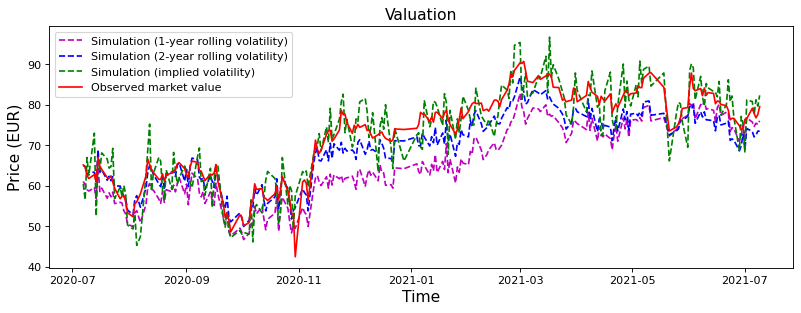

In [24]:
# plot the results of the different valuation approaches

fig = plt.figure(figsize=(12, 4), dpi=80)
plt.plot(data_subset["Date"], EC_sim_prices_1y, 'm--', label = "Simulation (1-year rolling volatility)");
plt.plot(data_subset["Date"], EC_sim_prices_2y, 'b--', label = "Simulation (2-year rolling volatility)");
plt.plot(data_subset["Date"], EC_sim_prices_impVol, 'g--', label = "Simulation (implied volatility)");
plt.plot(data_subset["Date"], data_subset["EC"], 'r', label = "Observed market value");

plt.xlabel("Time", fontsize=14)
plt.ylabel("Price (EUR)", fontsize=14)
plt.title("Valuation", fontsize=14)
plt.legend();

In [25]:
# compute error statistics of the different valuation approaches

print('RMSE with 1-year volatility: {:.4f}'.format(RMSE(EC_sim_prices_1y, data_subset["EC"])))
print('RMSE with 2-year volatility: {:.4f}'.format(RMSE(EC_sim_prices_2y, data_subset["EC"])))
print('RMSE with implied volatility: {:.4f}'.format(RMSE(EC_sim_prices_impVol, data_subset["EC"])))

print('\nMAE with 1-year volatility: {:.4f}'.format(MAE(EC_sim_prices_1y, data_subset["EC"])))
print('MAE with 2-year volatility: {:.4f}'.format(MAE(EC_sim_prices_2y, data_subset["EC"])))
print('MAE with implied volatility: {:.4f}'.format(MAE(EC_sim_prices_impVol, data_subset["EC"])))

print("\nAbsolute Error Quantiles with 1-year volatility: {}".format(ErrorQuantile(EC_sim_prices_1y, data_subset["EC"])))
print("Absolute Error Quantiles with 2-year volatility: {}".format(ErrorQuantile(EC_sim_prices_2y, data_subset["EC"])))
print("Absolute Error Quantiles with implied volatility {}".format(ErrorQuantile(EC_sim_prices_impVol, data_subset["EC"])))

RMSE with 1-year volatility: 8.0190
RMSE with 2-year volatility: 4.4502
RMSE with implied volatility: 4.4743

MAE with 1-year volatility: 7.0695
MAE with 2-year volatility: 3.6784
MAE with implied volatility: 3.6325

Absolute Error Quantiles with 1-year volatility: {'0.25 Quantile': 3.9402, '0.5 Quantile': 6.9446, '0.75 Quantile': 10.1544}
Absolute Error Quantiles with 2-year volatility: {'0.25 Quantile': 1.4171, '0.5 Quantile': 3.5092, '0.75 Quantile': 5.5129}
Absolute Error Quantiles with implied volatility {'0.25 Quantile': 1.6826, '0.5 Quantile': 3.2471, '0.75 Quantile': 4.9847}


# Part V: Sensitivity Analysis <a id="V"></a>

In [26]:
# do sensitivity analysis roughly one, three, six month(s) before the second observation date (16.07.2021) -> 16.06.2021 etc.
# for estimating the Greeks via simulation, still the same M = 1,000 with the same random numbers are used
ind_dates = [121, 196, 232]

# define sensible range of stock value to compute the Greeks for
range_stock = [i*0.25 for i in range(int(4/0.25), int(17.5/0.25))]

## Delta

In [27]:
# compute delta by finite difference approximations: compute the EC price for S+0.5 and S-0.5
# with the other parameters remaining constant and derive delta as the [C(S+0.5)-C(S-0.5)]/1

def compute_delta(S0, sigma, r, T_t0, M, r_num):
  S = S0 + 0.5
  simulated_paths = simulate(S, sigma, r, T_t0, M, r_num)

  prices_obs_dates = []
  for j in range(M):
    path = simulated_paths[j][::-1] # reverse list
    obs_dates_left = sum([x < len(path) for x in dist_obs_days])
    path_obs_dates = [path[dist_obs_days[::-1][l]] for l in range(obs_dates_left)]
    prices_obs_dates.append(path_obs_dates)
  
  EC_newS_plus = (np.exp(-r*T_t0)*np.mean(derive_payoff(prices_obs_dates, S)))

  S = S0 - 0.5
  simulated_paths = simulate(S, sigma, r, T_t0, M, r_num)

  prices_obs_dates = []
  for j in range(M):
    path = simulated_paths[j][::-1] # reverse list
    obs_dates_left = sum([x < len(path) for x in dist_obs_days])
    path_obs_dates = [path[dist_obs_days[::-1][l]] for l in range(obs_dates_left)]
    prices_obs_dates.append(path_obs_dates)
  
  EC_newS_minus = (np.exp(-r*T_t0)*np.mean(derive_payoff(prices_obs_dates, S)))

  return EC_newS_plus-EC_newS_minus

In [28]:
# compute the delta for each of the dates and each stock value defined in range_stock

deltas_overall = []

for obs_ind in ind_dates:
  deltas = []

  # specify parameters
  data_original = data_subset.iloc[obs_ind]
  sigma = data_original["Vol_2y"]/np.sqrt(240) # scale to daily
  r = data_original["R_f_daily"]
  T_t0 = data_original["T_t0"]
  r_num = rand_numbers[obs_ind*M:(obs_ind+1)*M,:]

  for i in tqdm(range(len(range_stock)), "Prices simulated"):
    deltas.append(compute_delta(range_stock[i], sigma, r, T_t0, M, r_num))

  deltas_overall.append(deltas)

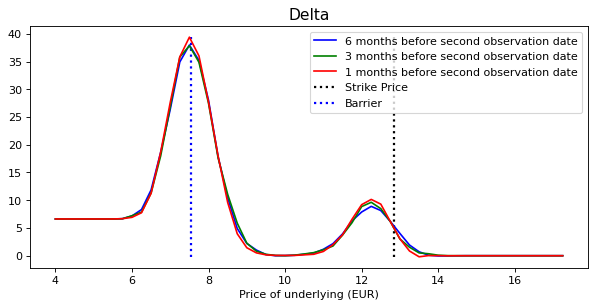

In [29]:
# plot delta

fig = plt.figure(figsize=(9,4), dpi=80)
plt.plot(range_stock, deltas_overall[0], 'b', label = "6 months before second observation date");
plt.plot(range_stock, deltas_overall[1], 'g', label = "3 months before second observation date");
plt.plot(range_stock, deltas_overall[2], 'r', label = "1 months before second observation date");
plt.vlines(x = 12.839, ymin=min(deltas_overall[2]), ymax = max(deltas_overall[2]), linewidth=2, linestyles ="dotted", colors ="k", label = "Strike Price")
plt.vlines(x = 7.533, ymin=min(deltas_overall[2]), ymax = max(deltas_overall[2]), linewidth=2, linestyles ="dotted", colors ="b", label = "Barrier")

plt.xlabel("Price of underlying (EUR)", fontsize=10)
plt.title("Delta", fontsize=14)
plt.legend();

## Gamma

In [30]:
# compute gamma via finite differences in the same way as implemented for delta

def compute_gamma(S0, sigma, r, T_t0, M, r_num):
  S = S0 + 0.5
  simulated_paths = simulate(S, sigma, r, T_t0, M, r_num)

  prices_obs_dates = []
  for j in range(M):
    path = simulated_paths[j][::-1] # reverse list
    obs_dates_left = sum([x < len(path) for x in dist_obs_days])
    path_obs_dates = [path[dist_obs_days[::-1][l]] for l in range(obs_dates_left)]
    prices_obs_dates.append(path_obs_dates)
  
  EC_newS_plus = (np.exp(-r*T_t0)*np.mean(derive_payoff(prices_obs_dates, S)))

  S = S0
  simulated_paths = simulate(S, sigma, r, T_t0, M, r_num)

  prices_obs_dates = []
  for j in range(M):
    path = simulated_paths[j][::-1] # reverse list
    obs_dates_left = sum([x < len(path) for x in dist_obs_days])
    path_obs_dates = [path[dist_obs_days[::-1][l]] for l in range(obs_dates_left)]
    prices_obs_dates.append(path_obs_dates)
  
  EC_newS = (np.exp(-r*T_t0)*np.mean(derive_payoff(prices_obs_dates, S)))

  S = S0 - 0.5
  simulated_paths = simulate(S, sigma, r, T_t0, M, r_num)

  prices_obs_dates = []
  for j in range(M):
    path = simulated_paths[j][::-1] # reverse list
    obs_dates_left = sum([x < len(path) for x in dist_obs_days])
    path_obs_dates = [path[dist_obs_days[::-1][l]] for l in range(obs_dates_left)]
    prices_obs_dates.append(path_obs_dates)
  
  EC_newS_minus = (np.exp(-r*T_t0)*np.mean(derive_payoff(prices_obs_dates, S)))

  return EC_newS_plus-2*EC_newS+EC_newS_minus

In [31]:
# compute the gamma for each of the dates and each stock value defined in range_stock

gammas_overall = []

for obs_ind in ind_dates:
  gammas = []

  data_original = data_subset.iloc[obs_ind]
  sigma = data_original["Vol_2y"]/np.sqrt(240) #scale to daily
  r = data_original["R_f_daily"]
  T_t0 = data_original["T_t0"]
  r_num = rand_numbers[obs_ind*M:(obs_ind+1)*M,:]

  for i in tqdm(range(len(range_stock)), "Prices simulated"):
    gammas.append(compute_gamma(range_stock[i], sigma, r, T_t0, M, r_num))

  gammas_overall.append(gammas)

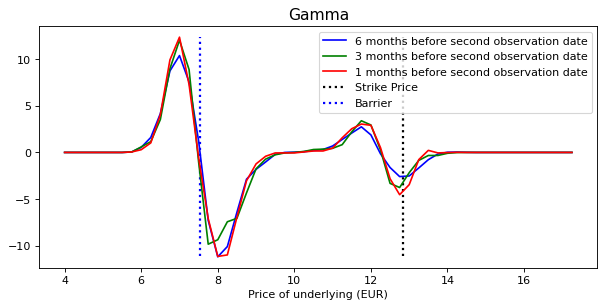

In [32]:
# plot gamma

fig = plt.figure(figsize=(9, 4), dpi=80)
plt.plot(range_stock, gammas_overall[0], 'b', label = "6 months before second observation date");
plt.plot(range_stock, gammas_overall[1], 'g', label = "3 months before second observation date");
plt.plot(range_stock, gammas_overall[2], 'r', label = "1 months before second observation date");
plt.vlines(x = 12.839, ymin=min(gammas_overall[2]), ymax = max(gammas_overall[2]), linewidth=2, linestyles ="dotted", colors ="k", label = "Strike Price")
plt.vlines(x = 7.533, ymin=min(gammas_overall[2]), ymax = max(gammas_overall[2]), linewidth=2, linestyles ="dotted", colors ="b", label = "Barrier")

plt.xlabel("Price of underlying (EUR)", fontsize=10)
plt.title("Gamma", fontsize=14)
plt.legend();

## Vega

In [33]:
# compute gamma via finite differences in the same way as implemented for the previous Greeks
# here, use sigma = 5% as low volatility and sigma = 50% as high volatility

def compute_vega(S, sigma, r, T_t0, M, r_num):
  sigma1 = 0.05
  simulated_paths = simulate(S, sigma1, r, T_t0, M, r_num)

  prices_obs_dates = []
  for j in range(M):
    path = simulated_paths[j][::-1] # reverse list
    obs_dates_left = sum([x < len(path) for x in dist_obs_days])
    path_obs_dates = [path[dist_obs_days[::-1][l]] for l in range(obs_dates_left)]
    prices_obs_dates.append(path_obs_dates)
  
  EC_newVol_plus = (np.exp(-r*T_t0)*np.mean(derive_payoff(prices_obs_dates, S)))

  sigma2 = 0.5
  simulated_paths = simulate(S, sigma2, r, T_t0, M, r_num)

  prices_obs_dates = []
  for j in range(M):
    path = simulated_paths[j][::-1] # reverse list
    obs_dates_left = sum([x < len(path) for x in dist_obs_days])
    path_obs_dates = [path[dist_obs_days[::-1][l]] for l in range(obs_dates_left)]
    prices_obs_dates.append(path_obs_dates)
  
  EC_newVol_minus = (np.exp(-r*T_t0)*np.mean(derive_payoff(prices_obs_dates, S)))

  return (EC_newVol_plus-EC_newVol_minus)/(sigma2-sigma1)

In [34]:
# compute the vega for each of the dates and each stock value defined in range_stock

vega_overall = []

for obs_ind in ind_dates:
  vegas = []

  data_original = data_subset.iloc[obs_ind]
  sigma = data_original["Vol_2y"]/np.sqrt(240) # scale to daily
  r = data_original["R_f_daily"]
  T_t0 = data_original["T_t0"]
  r_num = rand_numbers[obs_ind*M:(obs_ind+1)*M,:]

  for i in tqdm(range(len(range_stock)), "Prices simulated"):
    vegas.append(compute_vega(range_stock[i], sigma, r, T_t0, M, r_num))

  vega_overall.append(vegas)

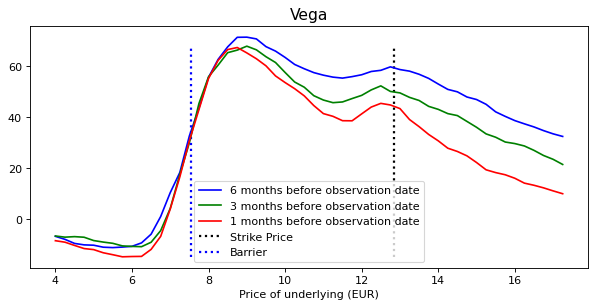

In [35]:
# plot vega

fig = plt.figure(figsize=(9, 4), dpi=80)
plt.plot(range_stock, vega_overall[0], 'b', label = "6 months before observation date");
plt.plot(range_stock, vega_overall[1], 'g', label = "3 months before observation date");
plt.plot(range_stock, vega_overall[2], 'r', label = "1 months before observation date");
plt.vlines(x = 12.839, ymin=min(vega_overall[2]), ymax = max(vega_overall[2]), linewidth=2, linestyles ="dotted", colors ="k", label = "Strike Price")
plt.vlines(x = 7.533, ymin=min(vega_overall[2]), ymax = max(vega_overall[2]), linewidth=2, linestyles ="dotted", colors ="b", label = "Barrier")

plt.xlabel("Price of underlying (EUR)", fontsize=10)
plt.title("Vega", fontsize=14)
plt.legend();

## Theta

In [36]:
# compute theta via finite differences in the same way as implemented for the previous Greeks
# here, compare EC price at current date and one day closer to maturity

def compute_theta(S, sigma, r, T_t0, M, r_num, d_t):
  T1 = T_t0
  simulated_paths = simulate(S, sigma, r, T1, M, r_num)

  prices_obs_dates = []
  for j in range(M):
    path = simulated_paths[j][::-1] # reverse list
    obs_dates_left = sum([x < len(path) for x in dist_obs_days])
    path_obs_dates = [path[dist_obs_days[::-1][l]] for l in range(obs_dates_left)]
    prices_obs_dates.append(path_obs_dates)
  
  EC_T = (np.exp(-r*T1)*np.mean(derive_payoff(prices_obs_dates, S)))

  T2 = T_t0 - d_t
  simulated_paths = simulate(S, sigma, r, T2, M, r_num)

  prices_obs_dates = []
  for j in range(M):
    path = simulated_paths[j][::-1] # reverse list
    obs_dates_left = sum([x < len(path) for x in dist_obs_days])
    path_obs_dates = [path[dist_obs_days[::-1][l]] for l in range(obs_dates_left)]
    prices_obs_dates.append(path_obs_dates)
  
  EC_newT = (np.exp(-r*T2)*np.mean(derive_payoff(prices_obs_dates, S)))

  return (EC_T-EC_newT)/(T2 - T1)

In [37]:
# compute the theta for each of the dates and each stock value defined in range_stock

d_t = 1/240
theta_overall = []

for i in range(len(ind_dates)):
  theta = []
  obs_ind = ind_dates[i]

  data_original = data_subset.iloc[obs_ind]
  sigma = data_original["Vol_2y"]/np.sqrt(240) # scale to daily
  r = data_original["R_f_daily"]
  T_t0 = data_original["T_t0"]
  r_num = rand_numbers[i*M:(i+1)*M,:]

  for i in tqdm(range(len(range_stock)), "Prices simulated"):
    theta.append(compute_theta(range_stock[i], sigma, r, T_t0, M, r_num, d_t))

  theta_overall.append(theta)

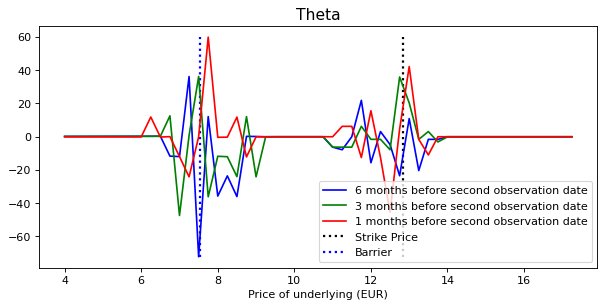

In [38]:
# plot theta

fig = plt.figure(figsize=(9, 4), dpi=80)
plt.plot(range_stock, theta_overall[0], 'b', label = "6 months before second observation date");
plt.plot(range_stock, theta_overall[1], 'g', label = "3 months before second observation date");
plt.plot(range_stock, theta_overall[2], 'r', label = "1 months before second observation date");
plt.vlines(x = 12.839, ymin=min(theta_overall[0]), ymax = max(theta_overall[2]), linewidth=2, linestyles ="dotted", colors ="k", label = "Strike Price")
plt.vlines(x = 7.533, ymin=min(theta_overall[0]), ymax = max(theta_overall[2]), linewidth=2, linestyles ="dotted", colors ="b", label = "Barrier")

plt.xlabel("Price of underlying (EUR)", fontsize=10)
plt.title("Theta", fontsize=14)
plt.legend();

# Part VI. Replicating Portfolio <a id="VI"></a>

In [39]:
# for set of parameters, simulate the EC price via Monte-Carlo simulation

def sim_EC_price(S, sigma, r, T, M, r_num):
  simulated_paths = simulate(S, sigma, mu, T, M, r_num) # simulate under physical measure

  prices_obs_dates = []
  for j in range(M):
    path = simulated_paths[j][::-1] # reverse list
    obs_dates_left = sum([x < len(path) for x in dist_obs_days])
    path_obs_dates = [path[dist_obs_days[::-1][l]] for l in range(obs_dates_left)]
    prices_obs_dates.append(path_obs_dates)
  
  return np.exp(-r*T)*(np.mean(derive_payoff(prices_obs_dates, S)))

In [40]:
measure = 12 # define monthly frequency
m_sim = 100 # number of paths

# set parameters of date of interest (last valuation date)
vol = data_subset["Vol_2y"].iloc[-1]
r = data_subset["R_f_daily"].iloc[-1]
start_data = data_subset.iloc[-1]

# estimate mu
daily_log_returns = [np.log(data["Stock"].iloc[i])-np.log(data["Stock"].iloc[i-1]) for i in range(1, data.shape[0])]
mu = np.mean(daily_log_returns)

# define further parameters
obs_to_mat = int(np.around(start_data["T_t0"]*measure))-1
C0 = data_subset["EC"].iloc[-1]
d_t = 1/measure

In [41]:
# initialize data frame and set seed for reproducability
rp_df = pd.DataFrame(np.nan, index = np.arange(obs_to_mat+1), columns = ["T", 'S', "delta", "S_before", "S_after", "B_before", "B_after", "Val_RP", "Val_EC", "Error"])
np.random.seed(42)

# iteratively conduct delta hedging by simulating new stock values, according deltas and stock + bond positions
# as well as simulate the EC price and determine the absolute hedging error 
rp_df["T"].iloc[0] = start_data["T_t0"]
rp_df["S"].iloc[0] = start_data["Stock"]
rp_df["delta"].iloc[0] = compute_delta(start_data["Stock"], vol, r, start_data["T_t0"], m_sim, rand_numbers[(data_subset.shape[0]-1)*M:(data_subset.shape[0])*M,:]) # use same random numbers as before
rp_df["S_before"].iloc[0] = 0
rp_df["S_after"].iloc[0] = rp_df["S"].iloc[0] * rp_df["delta"].iloc[0] 
rp_df["B_before"].iloc[0] = 0
rp_df["B_after"].iloc[0] = C0 - rp_df["S_after"].iloc[0]
rp_df["Val_RP"].iloc[0] = rp_df["S_after"].iloc[0] + rp_df["B_after"].iloc[0]
rp_df["Val_EC"].iloc[0] = sim_EC_price(rp_df["S"].iloc[0], vol, r, start_data["T_t0"], m_sim, rand_numbers[(data_subset.shape[0]-1)*M:(data_subset.shape[0])*M,:])
rp_df["Error"].iloc[0] = np.abs(rp_df["Val_RP"].iloc[0] - rp_df["Val_EC"].iloc[0])

for i in tqdm(range(1, obs_to_mat+1), "Dates left"):

  if i < obs_to_mat and start_data["T_t0"]-(i*d_t) > 1/measure:
    t_new = start_data["T_t0"]-(i*d_t)
    rp_df["T"].iloc[i] = t_new
    
    # determine S via brownian motion (see lecture 14, approximately min 22:30) & scale volatility to correct measure
    rp_df["S"].iloc[i] = rp_df["S"].iloc[i-1] + mu*rp_df["S"].iloc[i-1]*d_t+(vol/np.sqrt(measure))*rp_df["S"].iloc[i-1]*np.random.normal()*np.sqrt(d_t)
    rp_df["delta"].iloc[i] = compute_delta(rp_df["S"].iloc[i], vol, r, t_new, m_sim, rand_numbers[(data_subset.shape[0]-1)*M:(data_subset.shape[0])*M,:])
    rp_df["S_before"].iloc[i] = rp_df["S"].iloc[i] * rp_df["delta"].iloc[i-1] 
    rp_df["S_after"].iloc[i] = rp_df["S"].iloc[i] * rp_df["delta"].iloc[i] 
    rp_df["B_before"].iloc[i] = rp_df["B_after"].iloc[i-1]*np.exp(r*d_t)
    rp_df["B_after"].iloc[i] =  rp_df["B_before"].iloc[i] + (rp_df["S_before"].iloc[i] - rp_df["S_after"].iloc[i])
    rp_df["Val_RP"].iloc[i] = rp_df["S_after"].iloc[i] + rp_df["B_after"].iloc[i]
    rp_df["Val_EC"].iloc[i] = sim_EC_price(rp_df["S"].iloc[i], vol, r, t_new, m_sim, rand_numbers[(data_subset.shape[0]-1)*M:(data_subset.shape[0])*M,:])
    rp_df["Error"].iloc[i] = np.abs(rp_df["Val_RP"].iloc[i] - rp_df["Val_EC"].iloc[i])
    continue


  else:
    rp_df["T"].iloc[i] = 0
    rp_df["S"].iloc[i] = rp_df["S"].iloc[i-1] + mu*rp_df["S"].iloc[i-1]*d_t+(vol/np.sqrt(measure))*rp_df["S"].iloc[i-1]*np.random.normal()*np.sqrt(d_t)
    rp_df["delta"].iloc[i] = 0
    rp_df["S_before"].iloc[i] = rp_df["S"].iloc[i] * rp_df["delta"].iloc[i-1] 
    rp_df["S_after"].iloc[i] = 0
    rp_df["B_before"].iloc[i] = rp_df["B_after"].iloc[i-1]*np.exp(r*d_t)
    rp_df["B_after"].iloc[i] =  rp_df["B_before"].iloc[i] + (rp_df["S_before"].iloc[i] - rp_df["S_after"].iloc[i])
    rp_df["Val_RP"].iloc[i] = rp_df["S_after"].iloc[i] + rp_df["B_after"].iloc[i]
    rp_df["Val_EC"].iloc[i] = sim_EC_price(rp_df["S"].iloc[i], vol, r, t_new, m_sim, rand_numbers[(data_subset.shape[0]-1)*M:(data_subset.shape[0])*M,:])
    rp_df["Error"].iloc[i] = np.abs(rp_df["Val_RP"].iloc[i] - rp_df["Val_EC"].iloc[i])

In [42]:
print([i for i in range(rp_df.shape[0]) if rp_df["S"].iloc[i] > 12.839]) # check whether stock has been above strike price -> no
print(rp_df["Error"].mean()) # average absolute hedging error
rp_df.head(5)

[]
2.15642939555934


,T,S,delta,S_before,S_after,B_before,B_after,Val_RP,Val_EC,Error
0,3.295833,10.040000,6.740225,0.000000,67.671862,0.000000,11.828138,79.500000,79.544087,0.044087
1,3.212500,10.257631,9.081548,69.138745,93.155172,11.827680,-12.188747,80.966425,79.389297,1.577129
2,3.129167,10.194805,8.003103,92.584609,81.590072,-12.188275,-1.193738,80.396334,80.270213,0.126121
3,3.045833,10.483180,4.615958,83.897971,48.389917,-1.193692,34.314362,82.704279,83.416509,0.712229
4,2.962500,11.181481,5.593164,51.613247,62.539854,34.313035,23.386428,85.926282,86.369587,0.443305


In [43]:
rp_df.tail(5)

,T,S,delta,S_before,S_after,B_before,B_after,Val_RP,Val_EC,Error
35,0.379167,7.938447,11.833358,99.806042,93.938490,-30.019184,-24.151632,69.786858,74.898880,5.112021
36,0.295833,7.513554,9.673179,88.910579,72.679955,-24.150698,-7.920074,64.759881,69.374398,4.614517
37,0.212500,7.581728,13.435344,73.339412,101.863123,-7.919768,-36.443479,65.419644,69.811370,4.391726
38,0.129167,6.930674,16.724267,93.115985,115.910440,-36.442070,-59.236525,56.673916,57.795491,1.121576
39,0.000000,6.527148,0.000000,109.161762,0.000000,-59.234234,49.927528,49.927528,52.394221,2.466693


# Part VII. Performance Analysis <a id="VII"></a>

In [44]:
# For given set of parameters, simulate M times the path of the underlying 
# until maturity and derive the payoffs. Then, invest it at the risk-free rate 
# until maturity to obtain a payoff at maturity if the EC is called in same of 
# the observation dates.

def payoffs_paths(S, sigma, mu, r, T, M):
  np.random.seed(42) # ensure reproducible results
  r_num = np.random.normal(size=[M, int(T*240)])
  simulated_paths = simulate(S, sigma, mu, T, M, r_num) # simulate M paths

  # derive payoffs of M paths
  prices_obs_dates = []
  for j in range(M):
    path = simulated_paths[j][::-1] # reverse list
    obs_dates_left = sum([x < len(path) for x in dist_obs_days])
    path_obs_dates = [path[dist_obs_days[::-1][l]] for l in range(obs_dates_left)]
    prices_obs_dates.append(path_obs_dates)
  payoffs = derive_payoff(prices_obs_dates, S)
  
  # extend intermediate payoffs until maturity using the risk-free rate
  for i in range(M):
    if payoffs[i] == 106.50: 
      payoffs[i] = payoffs[i]*np.exp(r*4)
      continue
    elif payoffs[i] == 113:
      payoffs[i] = payoffs[i]*np.exp(r*3)
      continue
    elif payoffs[i] == 119.50:
      payoffs[i] = payoffs[i]*np.exp(r*2)
      continue
    elif payoffs[i] == 126:
      payoffs[i] = payoffs[i]*np.exp(r*1) 
      continue

  return payoffs

In [45]:
ind_PA = -1 # start date: last valuation day
days_to_sim = data["T_t0"].iloc[ind_PA]
M = 10000
vol = data["Vol_1y"].iloc[ind_PA] # use 1-year rolling volatility because better describes market environment at this point
r = data["R_f_daily"].iloc[ind_PA]

In [46]:
payoffs = payoffs_paths(data["Stock"].iloc[ind_PA], vol, mu, r, days_to_sim, M) # determine payoffs

In [47]:
# determine pessimistic, moderate and optimistic payoffs using the respective 
# quantiles of the payoff distribution at maturity

quants = [0.1, 0.5, 0.9]
payoffs_quant = list(np.quantile(payoffs, quants))

investment = 10000

ECs_bought = investment/data["EC"].iloc[ind_PA]
print("ECs bought:", ECs_bought * data["EC"].iloc[ind_PA])

# calculate annual returns of the investor for each scenario
for i in range(len(payoffs_quant)):
  ret = ECs_bought * payoffs_quant[i]
  print("\nQuantile:", quants[i])
  print("Payoff:", np.around(ret, 2))
  print("Annual return:", np.around(np.power(ret/investment, (1/days_to_sim))-1, 4))

ECs bought: 10000.0

Quantile: 0.1
Payoff: 2052.16
Annual return: -0.3815

Quantile: 0.5
Payoff: 12578.62
Annual return: 0.0721

Quantile: 0.9
Payoff: 15841.7
Annual return: 0.1498


# Part VIII. Stress Scenario Analysis <a id="VIII"></a>

In [48]:
# load historical stock prices of Lufthansa of the past five years
# (Source: https://www.onvista.de/aktien/times+sales/Lufthansa-Aktie-DE0008232125)

LHA_5y = pd.read_csv("data/LHA_5y.csv", sep = ";", decimal = ",") 
LHA_5y.shape

(262, 6)

In [49]:
vol_returns = Hist_Vol(LHA_5y, "Schluss", 63) # compute rolling (63 days) historical volatilities of stock returns
vol_returns = [i for i in vol_returns if i != 0] # remove first 63 observations for which no volatility can be calculated
stressed_vol = np.quantile(vol_returns, 0.9) # determine 90% quantile

## Plot

In [50]:
# the resulting volatility distribution is approximated using non-parametric kernel density estimation
kde = KernelDensity(kernel='gaussian', bandwidth=0.005).fit(np.array(vol_returns).reshape(len(vol_returns), 1))

# data for plotting
dx = 0.0001
X  = np.arange(min(vol_returns) - 0.05, max(vol_returns) + 0.05, dx) [:, np.newaxis]
Y  = np.exp(kde.score_samples(X))

# Normalize the data to a proper PDF
Y /= (dx * Y).sum()

# Compute the CDF
CY = np.cumsum(Y * dx)

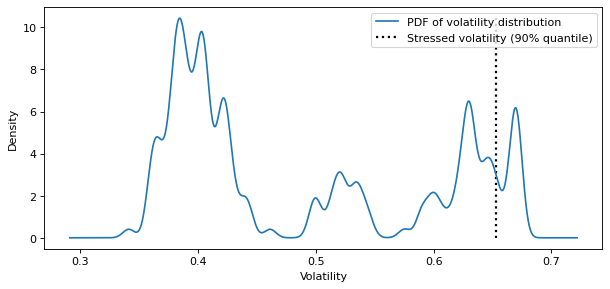

In [51]:
# plot PDF

fig = plt.figure(figsize=(9, 4), dpi=80)
plt.plot(X, Y, label = "PDF of volatility distribution");
plt.vlines(x = stressed_vol, ymin=0, ymax = max(Y), linewidth=2, linestyles ="dotted", colors ="k", label = "Stressed volatility (90% quantile)")
plt.xlabel("Volatility", fontsize=10)
plt.ylabel("Density", fontsize=10)
#plt.title("PDF of the stressed volatility", fontsize=14)
plt.legend();

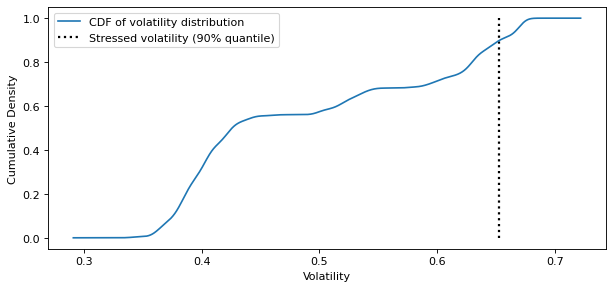

In [52]:
# plot CDF

fig = plt.figure(figsize=(9, 4), dpi=80)
plt.plot(X, CY, label = "CDF of volatility distribution");
plt.vlines(x = stressed_vol, ymin=0, ymax = max(CY), linewidth=2, linestyles ="dotted", colors ="k", label = "Stressed volatility (90% quantile)")
plt.xlabel("Volatility", fontsize=10)
plt.ylabel("Cumulative Density", fontsize=10)
#plt.title("CDF of the stressed volatility", fontsize=14);
plt.legend(loc='upper left');

## Stress scenario

In [53]:
# retrieve, once again, parameters of last valuation date for analysis

days_to_sim = data["T_t0"].iloc[-1]
r = data["R_f_daily"].iloc[-1]
M = 10000

In [54]:
payoffs_stressed = payoffs_paths(data["Stock"].iloc[-1], stressed_vol, mu, r, days_to_sim, M) # compute stressed payoff distribution

In [55]:
investment = 10000

ECs_bought = investment/data["EC"].iloc[-1]
print("ECs bought:", ECs_bought * data["EC"].iloc[-1])

ret = ECs_bought * np.quantile(payoffs_stressed, 0.05) # compute investors return in scerss scanrio (5% quantile of payoff distribution)
print(ret)
print(np.power(ret/investment, (1/days_to_sim))-1) # annual return

ECs bought: 10000.0
622.1904297823986
-0.5694137324576464


# Part IX. Risk Classification <a id="IX"></a>

In [56]:
# function used to compute the effective maturity by returning for each path T*payoff

def derive_mat(path):
  payoffs = []

  # first observation date
  try:
    if path[4] > 12.839:
      return 4 * 106.5

  except IndexError:
    pass


  # second observation date
  try:
    if path[3] > 12.839:
      return 3 * 113

  except IndexError:
    pass

    # third observation date
  try:
    if path[2] > 12.839:
      return 2 * 119.5

  except IndexError:
    pass


  # fourth observation date
  try:
    if path[1] > 12.839:
      return 1 * 126

  except IndexError:
    pass

  # maturity
  return 0 

In [57]:
ind = -1 # set index of data of analysis

# retrieve parameters 
T = data["T_t0"].iloc[ind]
vol = data["Vol_1y"].iloc[ind]
r = data["R_f_daily"].iloc[ind]
S = data["Stock"].iloc[ind]

# number of paths
M = 10000

In [58]:
np.random.seed(42) # ensure reproducible results
r_num = np.random.normal(size=[M, int(T*250)])

# simulate M paths until maturity under risk neutral measure
simulated_paths = simulate(S, vol, r, T, M, r_num)

# derive the discounted gross return distribution (prices_paths) as well as 
# payoffs and maturities to compute the effective maturity
prices_paths = []
maturities = []
payoffs = []
for j in range(M):
  path = simulated_paths[j][::-1] # reverse list
  obs_dates_left = sum([x < len(path) for x in dist_obs_days])
  path_obs_dates = [path[dist_obs_days[::-1][l]] for l in range(obs_dates_left)]
  price = np.exp(-r*T)*derive_payoff([path_obs_dates], S)[0]
  prices_paths.append(price/data["EC"].iloc[ind])
  maturities.append(derive_mat(path_obs_dates))
  payoffs.append(derive_payoff([path_obs_dates], S)[0])

In [59]:
# compute the 2.5% percentile of the distribution
VAR = np.quantile(prices_paths, 0.025)

# determine VEV and MRM
VEV = (np.sqrt(3.842-2*np.log(VAR)) - 1.96)/ np.sqrt(sum(maturities) / sum(payoffs))

if VEV < 0.005:
    MRM = 1
elif VEV < 0.05:
    MRM = 2
elif VEV < 0.12:
    MRM = 3
elif VEV < 0.2:
    MRM = 4
elif VEV < 0.3:
    MRM = 5
elif VEV < 0.8:
    MRM = 6
else:   
    MRM = 7

print("VEV:", VEV)
print("MRM:", MRM)

VEV: 0.7949532532513447
MRM: 6
